# Library Late Return Project:  Build a model to predict the likelihood of a late return of any book at checkout time

In this project, I will approach solving the problem in 4 steps in order to achieve the mission of the library. The mission statements are:

- To predict the likelihood of a late return of any book at checkout time.
- Identify factors that I can find that are connected with late returns.
- To make recommendations on what the library needs to do to mitigate the risks that I find.
- Present my findings in a very clear manner. 

These are the steps I would take to achieve the mission:

1. Importing relevant libraries, reading and joining the provided datasets into a master dataset (based on the provided schema below).
2. Data Cleaning and Transformation.
3. Exploratory Data Analysis.
4. Data Preparation and Predictive Modelling.

![title](schema.png)

## Step 1. Importing Libraries, Reading and Joining Datasets

In [1]:
#!pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing relevant libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re


import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None


libraries_df = pd.read_csv('./data/libraries.csv')
checkouts_df = pd.read_csv('./data/checkouts.csv')
customers_df = pd.read_csv('./data/customers.csv')
books_df = pd.read_csv('./data/books.csv')

### View what the dataframes look like by calling the pandas .head() method

In [4]:
libraries_df.head(2)

,id,name,street_address,city,region,postal_code
0,226-222@5xc-kc4-fpv,Multnomah County Library Capitol Hill,10723 SW capitol Hwy,Portland,OR,97219
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,NaN,or,NaN


In [5]:
checkouts_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2019-01-28,2018-11-13
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12


In [6]:
customers_df.head(2)

,id,name,street_address,city,state,zipcode,birth_date,gender,education,occupation
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE Meikle Pl,Portland,Oregon,97213.0,2009-09-10,female,High School,NaN
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE Harrison St,Portland,Oregon,97215.0,1956-12-15,female,College,Blue Collar


In [7]:
books_df.head(2)

,id,title,authors,publisher,publishedDate,categories,price,pages
0,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320
1,bRY9AAAAYAAJ,Foreign Publications for Advertising American ...,['United States. Bureau of Foreign and Domesti...,NaN,1913,['Advertising'],469.99,654


### Get the shape of the dataframes (rows X columns)

In [8]:
libraries_df.shape, checkouts_df.shape, customers_df.shape, books_df.shape

((18, 6), (2000, 5), (2000, 10), (240, 8))

### Join the dataframes into a master dataframe

1. Rename overlapping column names in the dataframes in order to have unique column names per dataframe

2. In order to have a master dataframe, it is necessary to identify the join keys in each of the dataframes.
   - books_df.id <==> checkouts_df.id
   - checkouts_df.patron_id <==> customers_df.id
   - checkouts_df.library_id <==> libraries_df.id

In [9]:
# Rename columns
from wrangler.data_preprocessing import rename_columns

In [10]:
renamed_lib = rename_columns(libraries_df, 'library_')
renamed_check = rename_columns(checkouts_df, 'checkout_')
renamed_customers = rename_columns(customers_df, 'customer_')
renamed_books = rename_columns(books_df, 'book_')

### New join key relationship upon renaming the columns
- renamed_books.book_id <==> renamed_check.checkout_id
- renamed_check.checkout_patron_id <==> renamed_customers.customer_id
- renamed_check.checkout_library_id <==> renamed_lib.library_id

In [11]:
# Merge the dataframes based on the renamed join keys 
books_checkouts = pd.merge(renamed_books, renamed_check, left_on='book_id', right_on='checkout_id')
bc_customers = pd.merge(books_checkouts, renamed_customers, left_on='checkout_patron_id', right_on='customer_id')
master_df = pd.merge(bc_customers, renamed_lib, left_on='checkout_library_id', right_on='library_id')

In [12]:
master_df.shape

(2000, 29)

In [13]:
master_df.head(2)

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,checkout_id,checkout_patron_id,checkout_library_id,checkout_date_checkout,checkout_date_returned,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,library_id,library_name,library_street_address,library_city,library_region,library_postal_code
0,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,hVFwAAAAQBAJ,466d78dd0a6e1beffc1ac2eb19fc17b4,226-222@5xc-jxj-7yv,2018-01-17,2018-01-31,466d78dd0a6e1beffc1ac2eb19fc17b4,Duncan Cruz,2931 SE Harrison St,Portland,Oregon,97214.0,1816-05-24,male,NaN,Sales,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE CESAR E CHAVEZ blvd,Portland,OR,97214
1,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,hVFwAAAAQBAJ,93500f374fb5f330d47e89b30af648f5,226-222@5xc-jxj-7yv,2018-04-05,2018-04-24,93500f374fb5f330d47e89b30af648f5,Robert Moretti,230 SW Woods st,Portland,Oregon,97201.0,2004-03-29,male,College,Admin & Support,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE CESAR E CHAVEZ blvd,Portland,OR,97214


In [ ]:
#master_df.to_csv("data/master_df.csv", index=False)

In [14]:
# Drop redundant join keys that are duplicates (across columns)
from wrangler.data_preprocessing import drop_cols

cols_to_drop = ['checkout_id','checkout_patron_id','checkout_library_id']
data = drop_cols(master_df, columns=cols_to_drop)

In [15]:
data.shape

(2000, 26)

## Step 2.  Data Cleaning and Feature Extraction

### 2.1- Cleaning and feature extraction opeerations:
- Featurize the datetime checkout and return columns into year, month, day
- Filter out invalid years (or years considered to be outliers)
- Compute the age of customers
- Create target column based on the 28 days period for lateness (0 for early returns and 1 for late returns)
- General function to clean columns by performing operations such as special character removal, leading/trailing whitespaces, etc
- Check the percentage of NaN values present in the dataset
- Detect and fix outliers
- Handle the NaN values (use mean for numeric and mode for categorical variables)

**Note**: The acronym wr stands for wrangle and are named from 1 to n to denote each step/progress

In [16]:
from wrangler.data_preprocessing import featurize_datetime
wr1 = featurize_datetime(data, ['checkout_date_checkout', 'checkout_date_returned'], drop = False)

In [17]:
wr1.head(2)

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,checkout_date_checkout,checkout_date_returned,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,checkout_date_checkout_year,checkout_date_checkout_month,checkout_date_checkout_day,checkout_date_returned_year,checkout_date_returned_month,checkout_date_returned_day
0,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,2018-01-17,2018-01-31,466d78dd0a6e1beffc1ac2eb19fc17b4,Duncan Cruz,2931 SE Harrison St,Portland,Oregon,97214.0,1816-05-24,male,NaN,Sales,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE CESAR E CHAVEZ blvd,Portland,OR,97214,2018.0,January,Wednesday,2018.0,January,Wednesday
1,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,2018-04-05,2018-04-24,93500f374fb5f330d47e89b30af648f5,Robert Moretti,230 SW Woods st,Portland,Oregon,97201.0,2004-03-29,male,College,Admin & Support,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE CESAR E CHAVEZ blvd,Portland,OR,97214,2018.0,April,Thursday,2018.0,April,Tuesday


In [18]:
#wr1.groupby('checkout_date_checkout_month')['book_title'].value_counts()['March']

In [18]:
wr1.shape

(2000, 32)

In [19]:
wr1.checkout_date_returned_year.astype(str).value_counts(normalize=True)[:7]

2018.0    0.8260
2019.0    0.0565
nan       0.0290
2112.0    0.0050
2117.0    0.0045
1802.0    0.0040
1807.0    0.0035
Name: checkout_date_returned_year, dtype: float64

In [20]:
# From the cell above, most of the dates outside 2018 & 2019 are either in the future or way in the past.
#Those will be filtered out
wr1.drop(wr1[(wr1['checkout_date_returned_year'] != 2018.0) & (wr1['checkout_date_returned_year'] != 2019.0)].index, inplace = True)
wr1.drop(wr1[(wr1['checkout_date_checkout_year'] != 2018.0) & (wr1['checkout_date_checkout_year'] != 2019.0)].index, inplace = True)
wr1 = wr1.reset_index(drop = True)
print('dataframe shape is {}'.format(wr1.shape))

dataframe shape is (1526, 32)


In [21]:
from wrangler.data_preprocessing import age

In [22]:
#Get the age of users using their birth date and checkout date
wr2 = age(wr1)

In [23]:
wr2.head(2)

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,checkout_date_checkout,checkout_date_returned,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,checkout_date_checkout_year,checkout_date_checkout_month,checkout_date_checkout_day,checkout_date_returned_year,checkout_date_returned_month,checkout_date_returned_day,customer_age
0,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,2018-01-17,2018-01-31,466d78dd0a6e1beffc1ac2eb19fc17b4,Duncan Cruz,2931 SE Harrison St,Portland,Oregon,97214.0,1816-05-24,male,NaN,Sales,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE CESAR E CHAVEZ blvd,Portland,OR,97214,2018.0,January,Wednesday,2018.0,January,Wednesday,202.0
1,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,2018-04-05,2018-04-24,93500f374fb5f330d47e89b30af648f5,Robert Moretti,230 SW Woods st,Portland,Oregon,97201.0,2004-03-29,male,College,Admin & Support,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE CESAR E CHAVEZ blvd,Portland,OR,97214,2018.0,April,Thursday,2018.0,April,Tuesday,14.0


In [25]:
from wrangler.data_preprocessing import create_target_column
wr3 = create_target_column(wr2)

In [26]:
#Create a new column target(0, 1) based on early/late returns
wr3.target.value_counts(normalize=True)

0    0.909028
1    0.090972
Name: target, dtype: float64

In [ ]:
# From the distribution in cell 27 above, the target is highly imbalanced

In [27]:
from wrangler.data_preprocessing import clean_columns

In [28]:
#General clean funtion
wr4 = clean_columns(wr3)

In [29]:
wr4.shape

(1451, 38)

In [30]:
from wrangler.data_preprocessing import check_nan

In [31]:
#Check the percentage distribution of NaN values in the dataset
check_nan(wr4)


------------------------- Count and Percentage of missing value -------------------------



,features,missing_counts,missing_percent
0,book_id,0,0.0
1,book_title,0,0.0
2,book_authors,409,28.2
3,book_publisher,899,62.0
4,book_publishedDate,15,1.0
5,book_categories,223,15.4
6,book_price,0,0.0
7,book_pages,0,0.0
8,checkout_date_checkout,0,0.0
9,checkout_date_returned,0,0.0


In [32]:
# Since 62% of the publisher column is missing (>50%), the column will be dropped
from wrangler.data_preprocessing import drop_cols
wr4 = drop_cols(wr4, ['book_publisher'])

In [141]:
# wr4.to_csv("data/master_df2.csv", index=False)

In [33]:
wr4.describe()

,book_price,book_pages,customer_zipcode,library_postal_code,checkout_date_checkout_year,checkout_date_returned_year,customer_age,period,target,book_age
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.0,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,15861.209511,590.717436,972362.667126,80933.437629,2018.0,2018.064094,39.988284,24.117161,0.090972,59.354928
std,17530.713757,170.540342,2089.555369,36311.766427,0.0,0.245004,48.466589,29.847683,0.287668,51.821006
min,0.000000,124.000000,970050.000000,0.000000,2018.0,2018.000000,-102.000000,5.000000,0.000000,-3.000000
25%,2802.500000,479.000000,972090.000000,97203.000000,2018.0,2018.000000,23.000000,11.000000,0.000000,13.000000
50%,5260.000000,587.000000,972160.000000,97212.000000,2018.0,2018.000000,40.000000,17.000000,0.000000,39.000000
75%,30099.000000,698.000000,972220.000000,97217.000000,2018.0,2018.000000,54.000000,23.000000,0.000000,106.000000
max,70799.000000,1154.000000,986850.000000,97239.000000,2018.0,2019.000000,219.000000,179.000000,1.000000,189.000000


In [34]:
#detect, fix outliers before handling NaN values
from wrangler.data_preprocessing import detect_fix_outliers, handle_nan
wr5 = detect_fix_outliers(wr4, target_column='target', verbose=False)
wr5 = handle_nan(wr5)

In [35]:
check_nan(wr5)


------------------------- Count and Percentage of missing value -------------------------



,features,missing_counts,missing_percent
0,book_id,0,0.0
1,book_title,0,0.0
2,book_authors,0,0.0
3,book_publishedDate,0,0.0
4,book_categories,0,0.0
5,book_price,0,0.0
6,book_pages,0,0.0
7,checkout_date_checkout,0,0.0
8,checkout_date_returned,0,0.0
9,customer_id,0,0.0


In [36]:
wr5.head(2)

,book_id,book_title,book_authors,book_publishedDate,book_categories,book_price,book_pages,checkout_date_checkout,checkout_date_returned,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,checkout_date_checkout_year,checkout_date_checkout_month,checkout_date_checkout_day,checkout_date_returned_year,checkout_date_returned_month,checkout_date_returned_day,customer_age,period,target,book_age,all_text,library_location
0,hVFwAAAAQBAJ,Ogilvy on Advertising,David Ogilvy,2013-09-11,Social Science,7299,320.0,2018-01-17,2018-01-31,466d78dd0a6e1beffc1ac2eb19fc17b4,Duncan Cruz,2931 SE Harrison St,portland,oregon,972140.0,1816-05-24,male,nan,sales,226-222@5xc-jxj-7yv,multnomah county library belmont,1038 SE CESAR E CHAVEZ blvd,portland,or,97214.0,2018.0,January,Wednesday,2018.0,January,Wednesday,48.670572,14.0,0,4.0,Ogilvy on Advertising David Ogilvy Social Science,belmont
1,hVFwAAAAQBAJ,Ogilvy on Advertising,David Ogilvy,2013-09-11,Social Science,7299,320.0,2018-04-05,2018-04-24,93500f374fb5f330d47e89b30af648f5,Robert Moretti,230 SW Woods st,portland,oregon,972010.0,2004-03-29,male,college,admin & support,226-222@5xc-jxj-7yv,multnomah county library belmont,1038 SE CESAR E CHAVEZ blvd,portland,or,97214.0,2018.0,April,Thursday,2018.0,April,Tuesday,14.000000,19.0,0,5.0,Ogilvy on Advertising David Ogilvy Social Science,belmont


## Step 3: Exploratory Data Analysis

### 3.1- Visualizations
- Word cloud 
- Target distribution and general stats
- Pie chart of day of week and returns
- Bar chart of customer city and occupation
- Bin age and plot a bar chart of the binned age distribution
- Double plotter of library location
- Line chart of patronage per month(checkouts)
- Line chart of books returned by month
- Double plotter of cities and occupation in the library data
- Frequency plotter of the education of customers

In [37]:
from wordcloud import WordCloud
from wrangler.text_preprocess import preprocess_document_for_fine_tuning
#from wrangler.utils import word_cloud
word_cloud_list = []
for index, row in wr5.iterrows():
    document = preprocess_document_for_fine_tuning(row['all_text'].strip()) 
    word_cloud_list.append(document)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/afolabiadeshola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
from wrangler.viz import word_cloud

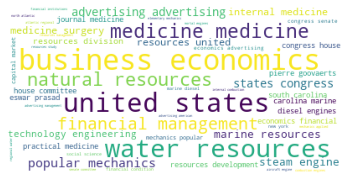

In [39]:
word_cloud(word_cloud_list)

### 3.2 - Target Distribution

In [41]:
#Class distribution in the dataset
wr5.target.value_counts(normalize=True) * 100

0    90.902826
1     9.097174
Name: target, dtype: float64

- The class distribution for early vs late returns is approximately 91 to 9%, which means more often than not, people return books early enough to the library.
- This is a highly imbalanced dataset

### 3.2 Average of some relevant fields (General Stats)

In [42]:
round(wr5.customer_age.mean())

39

In [43]:
round(wr5.period.mean())

17

In [44]:
round(wr5.book_pages.mean())

589

### 3.3 - Days of the week and book returns

In [45]:
from wrangler.viz import plot_pie

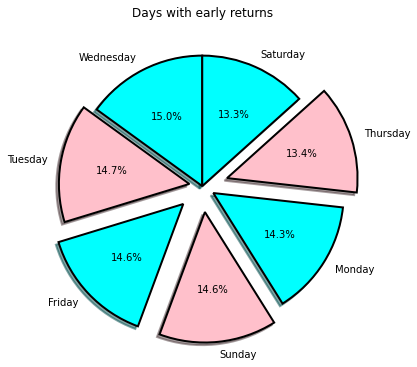

In [46]:
plot_pie(wr5, 0, (0.0, 0.1, 0.2, 0.2, 0.1, 0.2, 0.0), ("cyan", "pink"), 'Days with early returns', size = (11,6))

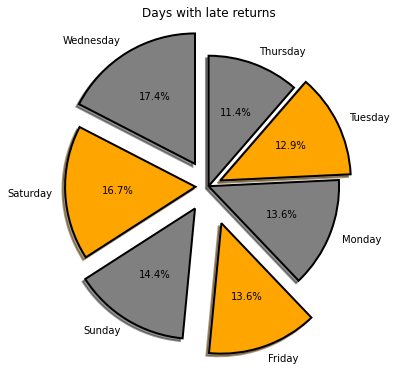

In [47]:
plot_pie(wr5, 1, (0.2, 0.1, 0.2, 0.3, 0.0, 0.1, 0.0), ("grey", "orange"), 'Days with late returns', size = (11,6))

### 3.4 - Occupation and late book returns

In [48]:
from wrangler.viz import bar_chart

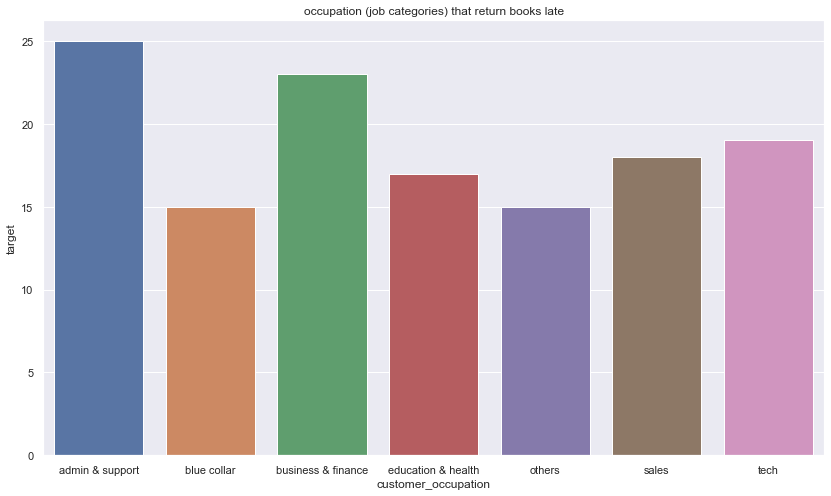

In [55]:
bar_chart(wr5, 'customer_occupation', 'target', 'occupation (job categories) that return books late')

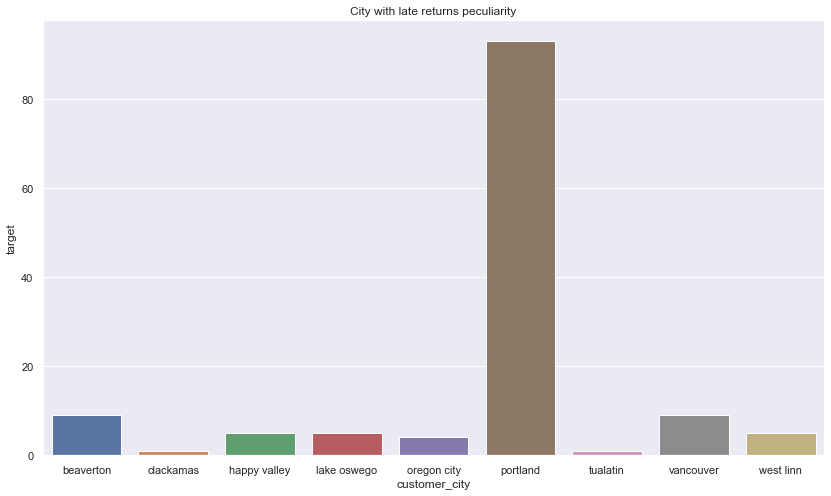

In [65]:
bar_chart(wr5, 'customer_city', 'target', 'City with late returns peculiarity')

In [66]:
from wrangler.data_preprocessing import bin_age

In [67]:
wr6 = bin_age(wr5, age_col = 'customer_age')

In [68]:
wr6.head(2)

,book_id,book_title,book_authors,book_publishedDate,book_categories,book_price,book_pages,checkout_date_checkout,checkout_date_returned,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,checkout_date_checkout_year,checkout_date_checkout_month,checkout_date_checkout_day,checkout_date_returned_year,checkout_date_returned_month,checkout_date_returned_day,customer_age,period,target,book_age,all_text,library_location,binned_customer_age
0,hVFwAAAAQBAJ,Ogilvy on Advertising,David Ogilvy,2013-09-11,Social Science,7299,320.0,2018-01-17,2018-01-31,466d78dd0a6e1beffc1ac2eb19fc17b4,Duncan Cruz,2931 SE Harrison St,portland,oregon,972140.0,1816-05-24,male,high school,sales,226-222@5xc-jxj-7yv,multnomah county library belmont,1038 SE CESAR E CHAVEZ blvd,portland,or,97214.0,2018.0,January,Wednesday,2018.0,January,Wednesday,48.670572,14.0,0,4.0,Ogilvy on Advertising David Ogilvy Social Science,belmont,Elderly
1,hVFwAAAAQBAJ,Ogilvy on Advertising,David Ogilvy,2013-09-11,Social Science,7299,320.0,2018-04-05,2018-04-24,93500f374fb5f330d47e89b30af648f5,Robert Moretti,230 SW Woods st,portland,oregon,972010.0,2004-03-29,male,college,admin & support,226-222@5xc-jxj-7yv,multnomah county library belmont,1038 SE CESAR E CHAVEZ blvd,portland,or,97214.0,2018.0,April,Thursday,2018.0,April,Tuesday,14.000000,19.0,0,5.0,Ogilvy on Advertising David Ogilvy Social Science,belmont,Child


In [69]:
#wr6.groupby('binned_customer_age')['book_title'].value_counts()['Elderly']

### 3.5 - Age demography with late returns peculiarity

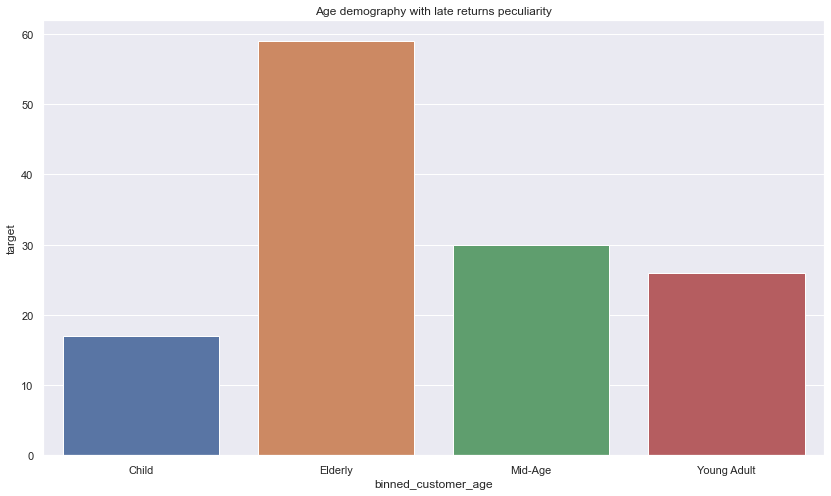

In [70]:
bar_chart(wr6, 'binned_customer_age', 'target', 'Age demography with late returns peculiarity')

### 3.6 - Multnomah County

In [71]:
from wrangler.viz import double_plotter

<AxesSubplot:title={'center':'return per Multnomah county library'}, xlabel='library_location'>

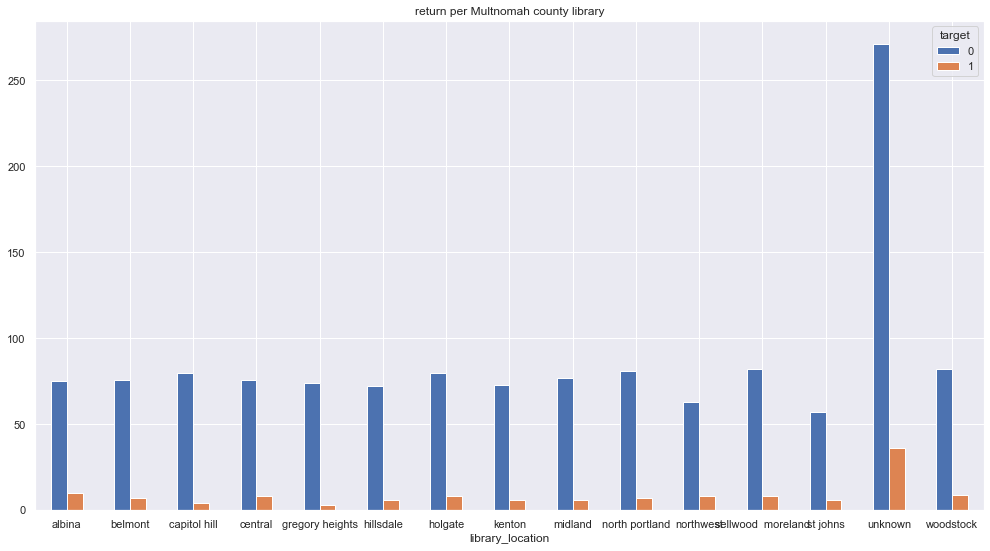

In [72]:
double_plotter(wr6, 'library_location', 'target', 'bar', (17,9), 
               title = 'return per Multnomah county library', rotation = 0)

### 3.7 - Patronage by month

<AxesSubplot:title={'center':'Patronage by month'}>

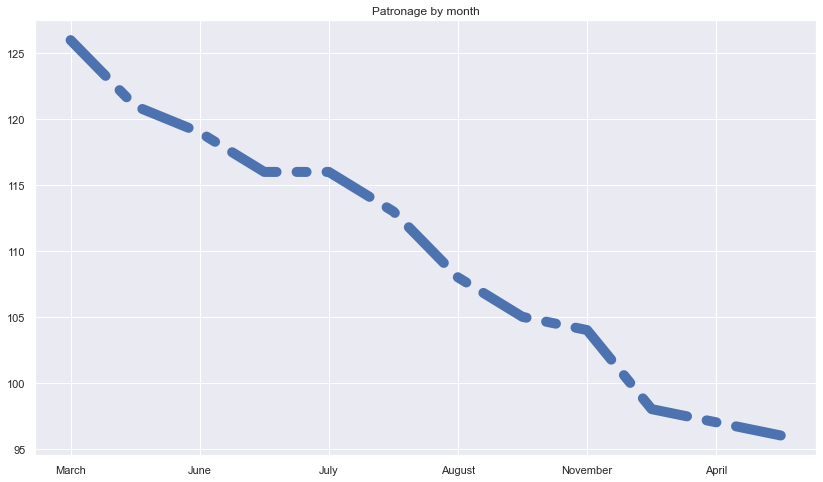

In [73]:
#what month of the year recieves the most patronage
wr6['checkout_date_checkout_month'].loc[wr6['target'] == 0].value_counts().plot(kind = 'line',
                                        linewidth=10,
                                        linestyle=(0, (5, 2, 1, 2)),
                                        dash_capstyle='round',
                                        title = 'Patronage by month')

<AxesSubplot:title={'center':'Books returned by month'}>

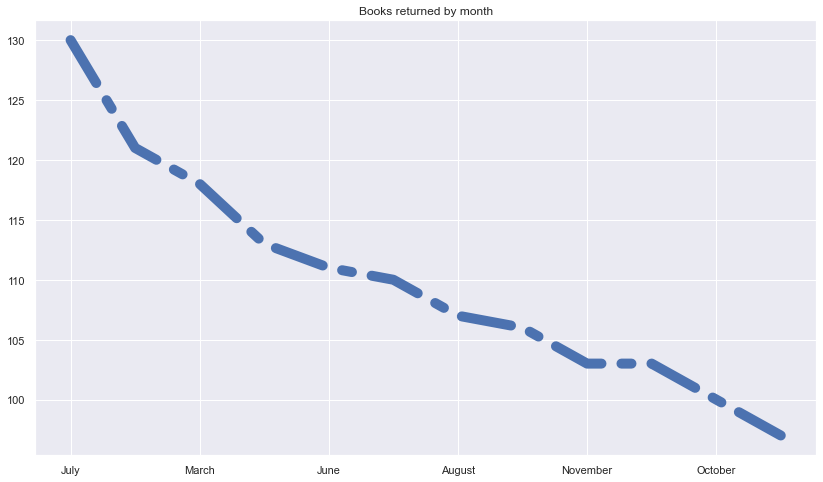

In [74]:
wr6['checkout_date_returned_month'].loc[wr6['target'] == 0].value_counts().plot(kind = 'line',
                                        linewidth=10,
                                        linestyle=(0, (5, 2, 1, 2)),
                                        dash_capstyle='round',
                                        title = 'Books returned by month')

### 3.8- Cities and occupation in Library's data

<AxesSubplot:title={'center':'Patronage by occupation'}, xlabel='customer_city'>

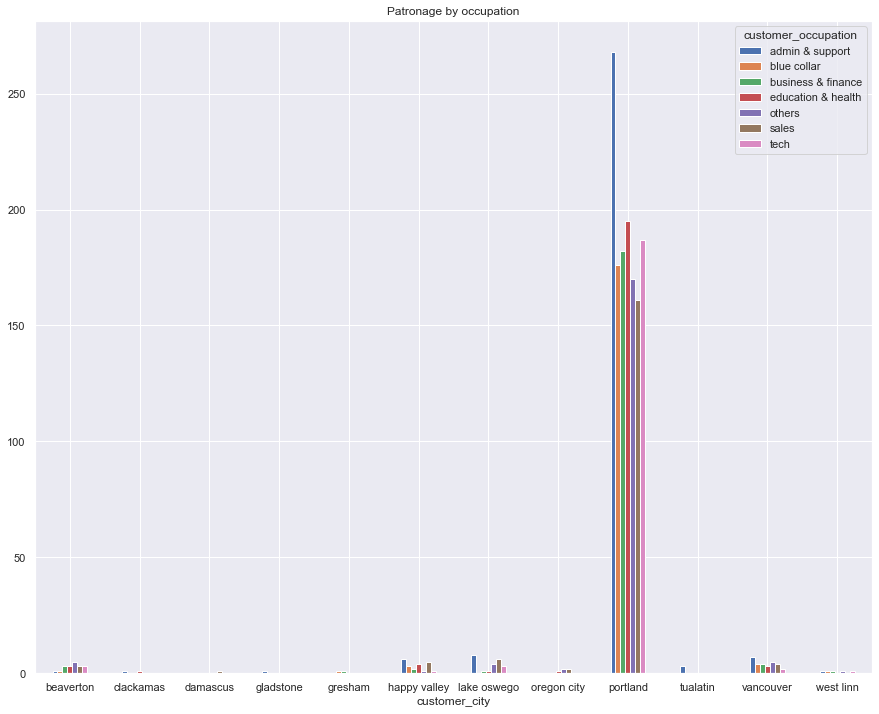

In [75]:
double_plotter(wr6, 'customer_city', 'customer_occupation', 'bar', (15,12), \
               title =  "Patronage by occupation", rotation = 0)

### 3.9- The education of customers

In [76]:
from wrangler.viz import frequency_plotter

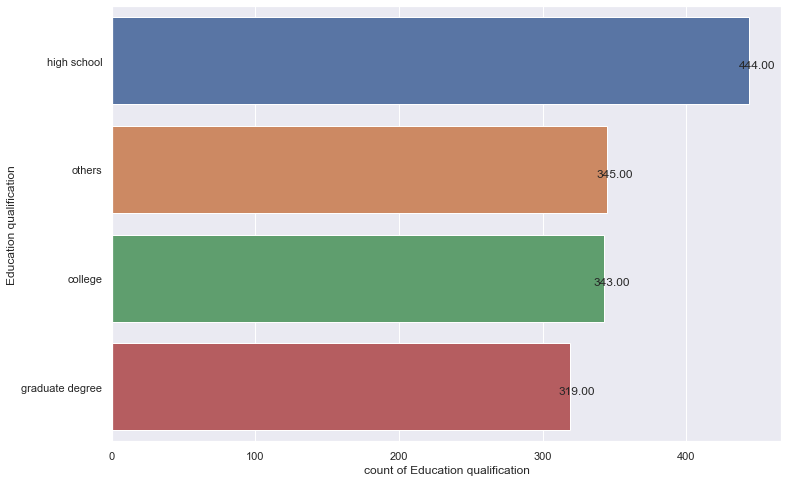

In [77]:
frequency_plotter(wr6, 'customer_education', 'count of Education qualification', 'Education qualification', (12,8))

## Step 4 - Data Preparation and Predictive Modeling

### 4.1- Import important libraries

In [78]:
#importing libraries and sub-modules for model building and evaluation
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

lr = LogisticRegression(solver = 'liblinear')
rfc = RandomForestClassifier(random_state = 42)
gbc = GradientBoostingClassifier(random_state = 42)


In [79]:
wr6.head(2)

,book_id,book_title,book_authors,book_publishedDate,book_categories,book_price,book_pages,checkout_date_checkout,checkout_date_returned,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,checkout_date_checkout_year,checkout_date_checkout_month,checkout_date_checkout_day,checkout_date_returned_year,checkout_date_returned_month,checkout_date_returned_day,customer_age,period,target,book_age,all_text,library_location,binned_customer_age
0,hVFwAAAAQBAJ,Ogilvy on Advertising,David Ogilvy,2013-09-11,Social Science,7299,320.0,2018-01-17,2018-01-31,466d78dd0a6e1beffc1ac2eb19fc17b4,Duncan Cruz,2931 SE Harrison St,portland,oregon,972140.0,1816-05-24,male,high school,sales,226-222@5xc-jxj-7yv,multnomah county library belmont,1038 SE CESAR E CHAVEZ blvd,portland,or,97214.0,2018.0,January,Wednesday,2018.0,January,Wednesday,48.670572,14.0,0,4.0,Ogilvy on Advertising David Ogilvy Social Science,belmont,Elderly
1,hVFwAAAAQBAJ,Ogilvy on Advertising,David Ogilvy,2013-09-11,Social Science,7299,320.0,2018-04-05,2018-04-24,93500f374fb5f330d47e89b30af648f5,Robert Moretti,230 SW Woods st,portland,oregon,972010.0,2004-03-29,male,college,admin & support,226-222@5xc-jxj-7yv,multnomah county library belmont,1038 SE CESAR E CHAVEZ blvd,portland,or,97214.0,2018.0,April,Thursday,2018.0,April,Tuesday,14.000000,19.0,0,5.0,Ogilvy on Advertising David Ogilvy Social Science,belmont,Child


In [80]:
wr6.shape

(1451, 38)

In [81]:
cols_to_drop = ['book_id','book_title','book_authors',\
                'book_publishedDate', 'book_categories','checkout_date_checkout',\
               'checkout_date_returned', 'customer_name', 'customer_street_address',\
               'customer_zipcode', 'customer_birth_date', 'library_id',\
               'library_name', 'library_street_address', 'library_postal_code']

Reason for dropping some columns:
- They are already featurized into other columns (i.e all date columns)
- They are informative at a high level (i.e addresses and names)
- Text fields such as book title will be converted into embeddings

In [83]:
from wrangler.data_preprocessing import drop_cols
wr7 = drop_cols(wr6, columns=cols_to_drop)

In [84]:
wr7.head(2)

,book_price,book_pages,customer_id,customer_city,customer_state,customer_gender,customer_education,customer_occupation,library_city,library_region,checkout_date_checkout_year,checkout_date_checkout_month,checkout_date_checkout_day,checkout_date_returned_year,checkout_date_returned_month,checkout_date_returned_day,customer_age,period,target,book_age,all_text,library_location,binned_customer_age
0,7299,320.0,466d78dd0a6e1beffc1ac2eb19fc17b4,portland,oregon,male,high school,sales,portland,or,2018.0,January,Wednesday,2018.0,January,Wednesday,48.670572,14.0,0,4.0,Ogilvy on Advertising David Ogilvy Social Science,belmont,Elderly
1,7299,320.0,93500f374fb5f330d47e89b30af648f5,portland,oregon,male,college,admin & support,portland,or,2018.0,April,Thursday,2018.0,April,Tuesday,14.000000,19.0,0,5.0,Ogilvy on Advertising David Ogilvy Social Science,belmont,Child


In [85]:
wr7.shape

(1451, 23)

### 4.2- Featurize the text column "all_text" to generate word embeddings
Note: this is at a high level way of generating text embeddings, future improvements would be:
- Include parts of speech tagging in the preprocess_document_for_fine_tuning function
- Apply Named Entity recognition to identify names (i.e names of Authors in this case)

In [86]:
from wrangler.text_preprocess import merge_emb
wr8 = merge_emb(wr7)

In [87]:
wr8.head(2)

,book_price,book_pages,customer_id,customer_city,customer_state,customer_gender,customer_education,customer_occupation,library_city,library_region,checkout_date_checkout_year,checkout_date_checkout_month,checkout_date_checkout_day,checkout_date_returned_year,checkout_date_returned_month,checkout_date_returned_day,customer_age,period,target,book_age,library_location,binned_customer_age,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,7299,320.0,466d78dd0a6e1beffc1ac2eb19fc17b4,portland,oregon,male,high school,sales,portland,or,2018.0,January,Wednesday,2018.0,January,Wednesday,48.670572,14.0,0,4.0,belmont,Elderly,-0.300482,-0.170635,-0.19725,-0.452872,0.454073,-0.22148,0.112343,-0.13979,-0.338362,0.09015,0.188847,-0.377322,0.000549,0.00665,0.094394,0.012761,0.150437,0.357539,-0.494483,0.297592,-0.065097,0.224311,0.441547,0.017875,0.40421,0.145288,0.508442,-0.403657,-0.306377,-0.390659,-0.222595,0.898632,-0.254782,-0.121327,-0.25246,0.140186,-0.884152,0.465702,-0.164912,0.50993,-0.184655,-0.022334,-0.616507,0.29501,-0.29565,-0.307975,-0.166617,0.203538,-0.255158,-0.514473,0.288347,-0.053268,-0.166447,0.287892,0.210304,-1.780063,0.058683,-0.00502,0.550613,0.296298,0.174563,-0.041547,-0.026002,0.099116,0.416482,0.042368,0.150624,0.292442,0.80956,0.107603,0.117608,0.366547,-0.351301,-0.395847,-0.274386,-0.200643,0.117443,-0.11232,-0.84845,-0.15145,0.275043,0.088183,0.154574,0.372817,-0.698767,-0.224033,-0.558094,-0.060824,0.097047,-0.573075,0.182008,-0.407173,0.446493,-0.178622,-0.043481,0.11859,0.099787,-0.473733,0.224313,0.331072
1,7299,320.0,93500f374fb5f330d47e89b30af648f5,portland,oregon,male,college,admin & support,portland,or,2018.0,April,Thursday,2018.0,April,Tuesday,14.000000,19.0,0,5.0,belmont,Child,-0.300482,-0.170635,-0.19725,-0.452872,0.454073,-0.22148,0.112343,-0.13979,-0.338362,0.09015,0.188847,-0.377322,0.000549,0.00665,0.094394,0.012761,0.150437,0.357539,-0.494483,0.297592,-0.065097,0.224311,0.441547,0.017875,0.40421,0.145288,0.508442,-0.403657,-0.306377,-0.390659,-0.222595,0.898632,-0.254782,-0.121327,-0.25246,0.140186,-0.884152,0.465702,-0.164912,0.50993,-0.184655,-0.022334,-0.616507,0.29501,-0.29565,-0.307975,-0.166617,0.203538,-0.255158,-0.514473,0.288347,-0.053268,-0.166447,0.287892,0.210304,-1.780063,0.058683,-0.00502,0.550613,0.296298,0.174563,-0.041547,-0.026002,0.099116,0.416482,0.042368,0.150624,0.292442,0.80956,0.107603,0.117608,0.366547,-0.351301,-0.395847,-0.274386,-0.200643,0.117443,-0.11232,-0.84845,-0.15145,0.275043,0.088183,0.154574,0.372817,-0.698767,-0.224033,-0.558094,-0.060824,0.097047,-0.573075,0.182008,-0.407173,0.446493,-0.178622,-0.043481,0.11859,0.099787,-0.473733,0.224313,0.331072


In [88]:
wr8.shape

(1379, 122)

### 4.3- Column Transformer Pipeline Object:
Steps Include:
- Identify numerical and categorical attributes
- For numerical attributes, fill missing values with mean and scale using standard scaler
- For categorical attributes, perform one hot encoding (OHE) and replace missing values with most_frequent

This helps for reproducibility especially if going to prod; to avoid any form of inconsistency

- The full pipeline object can be used to transform any data (after going through the data_preprocessing script)

In [89]:
from wrangler.pipeline import build_pipeline

In [91]:
processed = build_pipeline(wr8)

In [92]:
X, y, X_train, X_test, y_train, y_test, full_pipeline = processed.build_object()

(1103, 191)


## Modeling Approach
- I typically throw my data into a range of algorithms and I look out for the general metrics; what model is performing well, what model needs tuning and what model is overfitting
- Based on step 1 above, I start to iterate
- My standout metric for binary classification problems is the roc_auc
- I begin to tune, and monitor the performance of alogrithm based on several metrics

In [95]:
from wrangler.data_preprocessing import print_divider

In [97]:
def benchmark(x_train: np.array, y_train: np.array, x_test: np.array, y_test: np.array, classifiers: list):
    
    '''
    Play around with different ML algorithms using default parameters and 
    begin to minotor performance based on metric
    '''
    for classifier in classifiers:
        training = classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        score = 'Classifier_test_Score : {}'.format(classifier.score(x_test, y_test))
        recall = 'Classifier_recall_Score : {}'.format(recall_score(y_test, y_pred))
        f1 = 'Classifier_f1_Score : {}'.format(f1_score(y_test, y_pred))
        precision = 'Classifier_precision_Score : {}'.format(precision_score(y_test, y_pred))
        matrix_of_predictions = confusion_matrix(y_test, y_pred)
        print(training)
        print(score)
        print(recall)
        print(f1)
        print(precision)
        print(matrix_of_predictions)
        print_divider("Algorithm and metrics")

    
benchmark(X_train, y_train, X_test, y_test, classifiers = [lr, rfc, gbc])

LogisticRegression(solver='liblinear')
Classifier_test_Score : 0.9420289855072463
Classifier_recall_Score : 0.38461538461538464
Classifier_f1_Score : 0.5555555555555556
Classifier_precision_Score : 1.0
[[250   0]
 [ 16  10]]

------------------------- Algorithm and metrics -------------------------

RandomForestClassifier(random_state=42)
Classifier_test_Score : 0.9130434782608695
Classifier_recall_Score : 0.07692307692307693
Classifier_f1_Score : 0.14285714285714288
Classifier_precision_Score : 1.0
[[250   0]
 [ 24   2]]

------------------------- Algorithm and metrics -------------------------

GradientBoostingClassifier(random_state=42)
Classifier_test_Score : 1.0
Classifier_recall_Score : 1.0
Classifier_f1_Score : 1.0
Classifier_precision_Score : 1.0
[[250   0]
 [  0  26]]

------------------------- Algorithm and metrics -------------------------



From the above, here are my observations:
- The logistic regression model needs to be tuned, especially as there's class imbalance. Use of the class_weight param will come in handy here
- The random forest model didn't perform well. The accuracy is high due to the imabalanced target class, howeever, the precision, recall and f1 didn't meet the desired expectation
- The Gradient Boosting Classifier is overfitting. We need to introduce a cross validation or regularization technique if we are to use this

In [ ]:
# Test more algorithms

In [107]:
from numpy import mean
from numpy import std

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [105]:
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score,
                             precision_recall_curve,
                             roc_curve,
                             average_precision_score)

In [ ]:
classifiers = [
               KNeighborsClassifier(3),
               DecisionTreeClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               LGBMClassifier()
               ]

In [ ]:
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print_divider("Classifier Name")
    print(classifier)
    print_divider("metrics")
    print("model score: %.3f" % classifier.score(X_test, y_test))
    print('confusion matrix')
    print(confusion_matrix(y_test, y_pred))
    print('classification report')
    print(classification_report(y_test, y_pred))
    print('f1 score : %f' % (fbeta_score(y_test, y_pred, beta=0.5)))
    print("ROC AUC {:.4f}".format(roc_auc_score(y_test, y_pred)))
    print("Average precision score {:.4f}".format(average_precision_score(y_test, y_pred)))


------------------------- Classifier Name -------------------------

KNeighborsClassifier(n_neighbors=3)

------------------------- metrics -------------------------

model score: 0.902
confusion matrix
[[249   1]
 [ 26   0]]
classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       250
           1       0.00      0.00      0.00        26

    accuracy                           0.90       276
   macro avg       0.45      0.50      0.47       276
weighted avg       0.82      0.90      0.86       276

f1 score : 0.000000
ROC AUC 0.4980
Average precision score 0.0942

------------------------- Classifier Name -------------------------

DecisionTreeClassifier()

------------------------- metrics -------------------------

model score: 1.000
confusion matrix
[[250   0]
 [  0  26]]
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           

Apart from KNN, all tree alorithms were overfitting. 

In [386]:
from lightgbm import LGBMClassifier
from wrangler.util import get_scores


# Define model
clf = LGBMClassifier(scale_pos_weight=0.001)

clf.fit(X_train, y_train)
pred_prob = clf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
AP = average_precision_score(y_test, pred_prob[:,1])        
print(f'ROC_AUC Score is: {auc_score} and Average Precision score is: {AP}')

test_preds = clf.predict(X_test)

print (get_scores(y_test, test_preds))

ROC_AUC Score is: 0.9995384615384615 and Average Precision score is: 0.9960212201591511
{'accuracy': 0.9963768115942029, 'precision': 1.0, 'recall': 0.9615384615384616, 'f1': 0.9803921568627451, 'roc_auc': 0.9807692307692308, 'average_precision': 0.9651616499442587}


### From the above, lightgbm scale_pos_weight helps to maintain the class imbalance. The metrics look good and to be sure it is not overfitting, I would further explore cross validation with LightGBM at a later time.

### Further exploration with Logistic regression and a grid search of the ideal class weight to use

Best parameters : {'class_weight': {0: 0.14090909090909093, 1: 0.8590909090909091}}


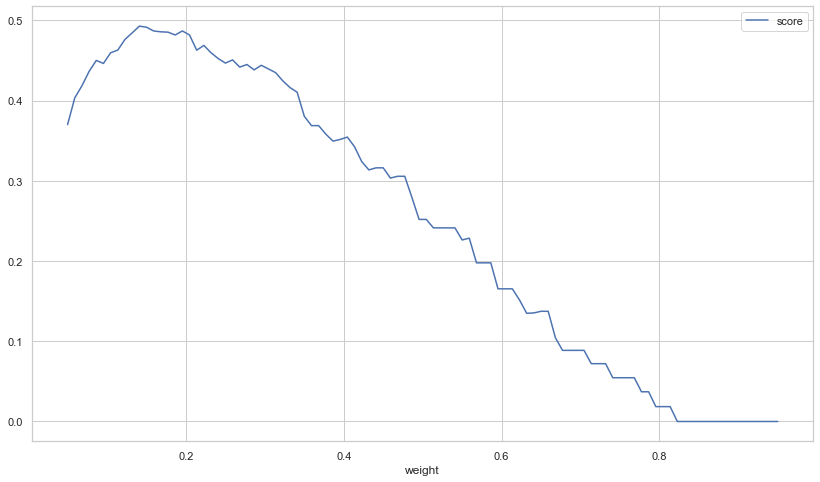

In [374]:
weights = np.linspace(0.05, 0.95, 100)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [377]:
lr = LogisticRegression(**grid_result.best_params_)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

get_scores(y_test, y_pred)

{'accuracy': 0.8840579710144928,
 'precision': 0.42105263157894735,
 'recall': 0.6153846153846154,
 'f1': 0.5,
 'roc_auc': 0.7636923076923078,
 'average_precision': 0.2953411957988617}

### Despite adjusting the class weights accordingly, I am not satisfied with the logistic regression metric

## Final Algorithm
- I will be settling for LightGBM using the scale_pos_weight param with cross validation
- I am satisfied with the metrics
- Based on this, I generate the feature importances of the algorithm
- The first bar chart shows the top 15 most important features and the second bar chart shows the least 15 important features

**Observation** : LightGBM is way faster than other tree based algorithm or ensemble algorithms as the case might be.

In [414]:
%%time
clf = LGBMClassifier(scale_pos_weight=0.001)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

clf = LGBMClassifier(scale_pos_weight=0.001)


clf.fit(X_train, y_train)
clf.score(X_test, y_test)


Mean ROC_AUC score: 0.998 (0.005)
CPU times: user 572 ms, sys: 81.5 ms, total: 653 ms
Wall time: 3.22 s


0.9963768115942029

In [415]:
pred_prob = clf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
AP = average_precision_score(y_test, pred_prob[:,1])        
print(f'ROC_AUC Score is: {auc_score} and Average Precision score is: {AP}')

test_preds = clf.predict(X_test)

print (get_scores(y_test, test_preds))

ROC_AUC Score is: 0.9995384615384615 and Average Precision score is: 0.9960212201591511
{'accuracy': 0.9963768115942029, 'precision': 1.0, 'recall': 0.9615384615384616, 'f1': 0.9803921568627451}


In [ ]:
from wrangler.utils import get_feature_names

In [419]:
feature_names = get_feature_names(full_pipeline)

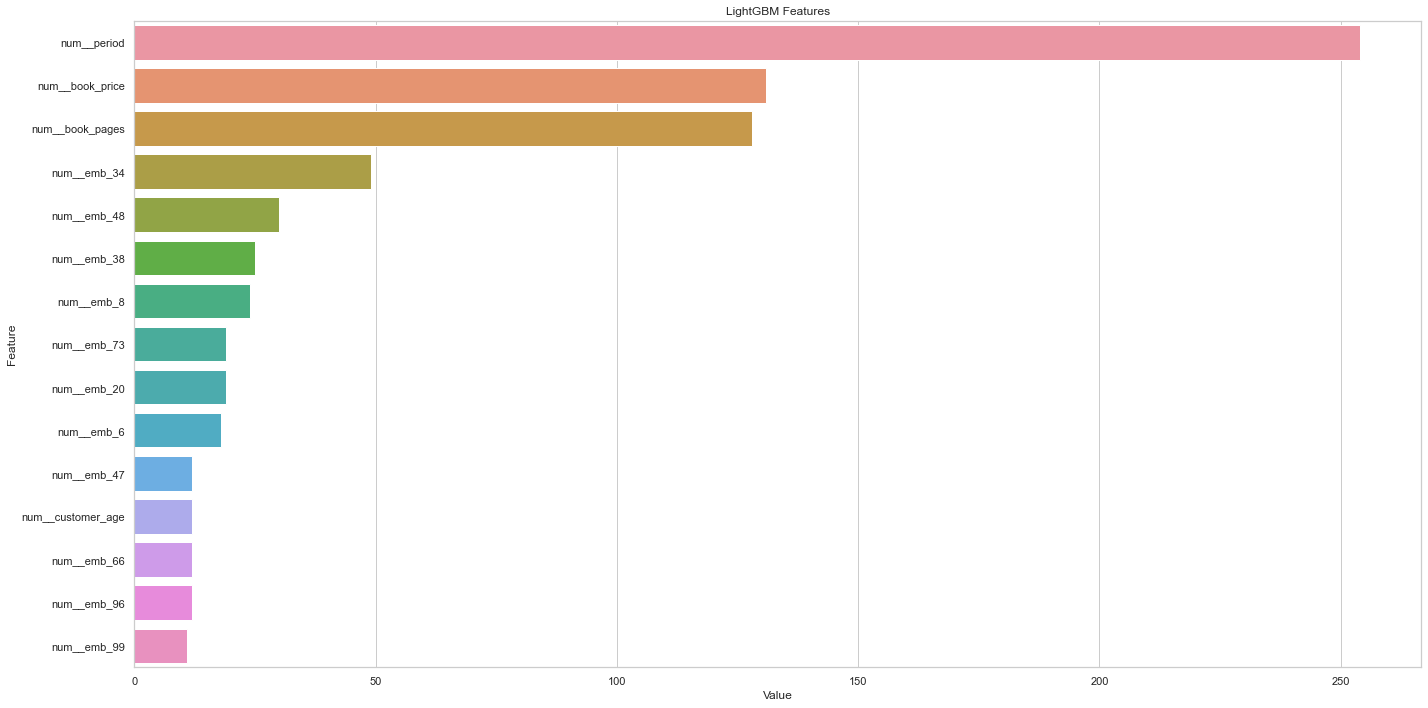

In [421]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,feature_names)), columns=['Value','Feature'])
#Most important features
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(15))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

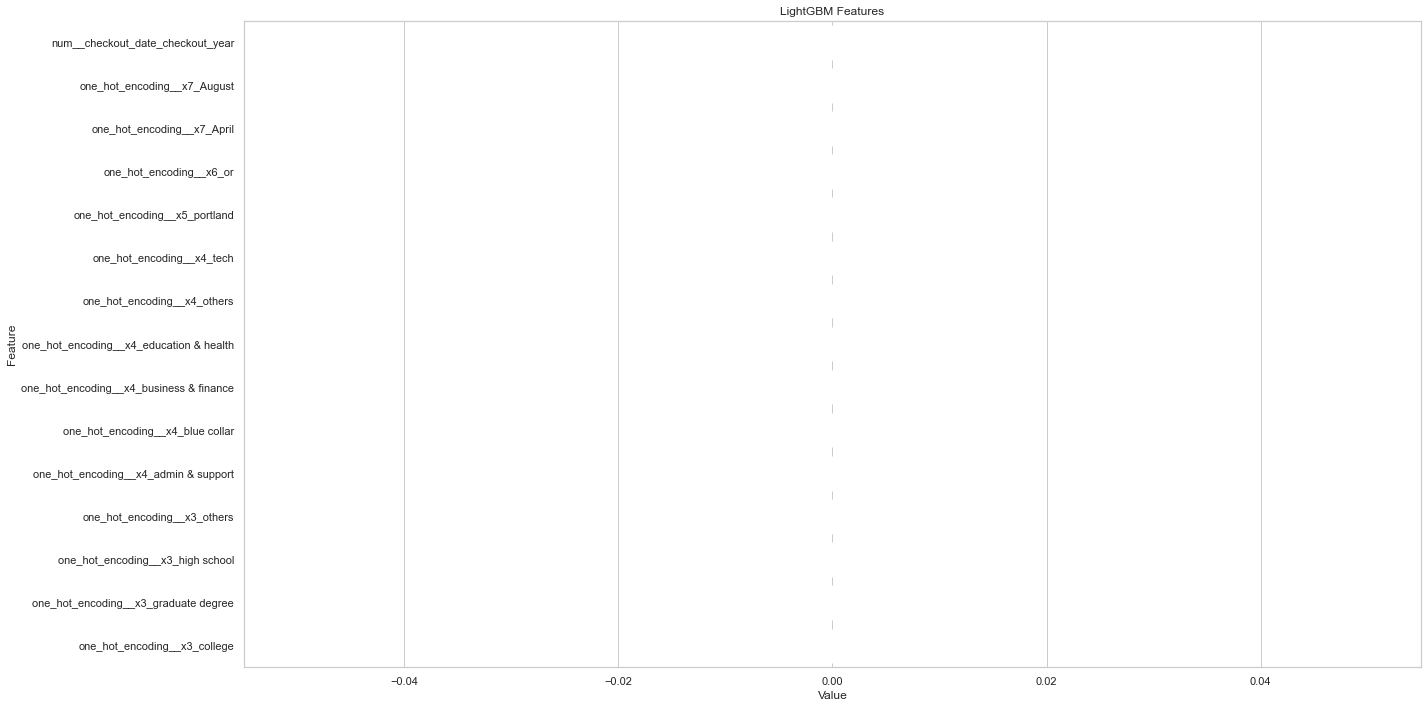

In [422]:
#Least important features
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=True).head(15))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()